In [3]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas for table creation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler

In [4]:
# ========================================
# 1. Data Loading and Preprocessing
# ========================================

folder_path = '/Users/shunli/Desktop/EP-LHb-model/DA clamp/Dataset'
files = os.listdir(folder_path)
file_path = [os.path.join(folder_path, file) for file in files]

animal1 = [file for file in file_path if 'Reward1' in file]
animal2 = [file for file in file_path if 'Reward2' in file]
animal3 = [file for file in file_path if 'Reward3' in file]


control = animal1 + animal2
inhibition = animal3

# Load signals and labels for control group
signals = []
labels = []
for file in control:
    with h5py.File(file, 'r') as f:
        signals.append(f['photometry_reshape'][:].T)
        labels.append(f['waterLick_reshape'][:].T)


signals = np.vstack(signals)
labels = np.vstack(labels)
print(f"Control Group Data Shape: {signals.shape}, Labels Shape: {labels.shape}")


Control Group Data Shape: (16647, 10000), Labels Shape: (16647, 1)


In [5]:
# ========================================
# 2. Data Balancing (Upsampling the Minority Class)
# ========================================

# Identify indices for positive and negative labels
idx_positive = np.where(labels == 1)[0]  # Water lick = 1
idx_negative = np.where(labels == 0)[0]  # Water lick = 0
# Upsample the minority class (negative samples) to balance the dataset
idx_upsampled = np.random.choice(idx_positive, size=len(idx_negative), replace=True)
idx_combined = np.concatenate([idx_negative, idx_upsampled])
np.random.shuffle(idx_combined)

# Apply balanced indices to the data
signals = signals[idx_combined]
labels = labels[idx_combined]
print(f"Class distribution after balancing: Licks = {np.count_nonzero(labels == 1)}, No Licks = {np.count_nonzero(labels == 0)}")

Class distribution after balancing: Licks = 15989, No Licks = 15989


In [6]:
# ========================================
# 3. Train-Test Split
# ========================================
scaler = StandardScaler()
signals = scaler.fit_transform(signals)

# Split data into 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(signals, labels, test_size=0.2, random_state=42)

# Further split training data into 80% for training, 20% for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [7]:
# ========================================
# 4. Logistic Regression Model
# ========================================

# Initialize logistic regression model
model = LogisticRegression(max_iter=1000)

# Train the model on the training data
model.fit(X_train, y_train)


/Users/shunli/miniconda3/envs/eplhbmodel/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shunli/miniconda3/envs/eplhbmodel/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [8]:
# ========================================
# 5. Model Evaluation (Control Group)
# ========================================

# Evaluate on validation set
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Control Group Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluate on test set (control group)
y_test_pred = model.predict(X_test)
test_accuracy_control = accuracy_score(y_test, y_test_pred)
print(f"Control Group Test Accuracy: {test_accuracy_control * 100:.2f}%")

# ROC curve and AUC for control group
y_test_prob = model.predict_proba(X_test)[:, 1]
fpr_control, tpr_control, thresholds_control = roc_curve(y_test, y_test_prob)
roc_auc_control = auc(fpr_control, tpr_control)
print(f"Control Group Test AUC: {roc_auc_control:.2f}")

Control Group Validation Accuracy: 94.96%
Control Group Test Accuracy: 94.82%
Control Group Test AUC: 0.99


In [9]:
# ========================================
# 6. Baseline Accuracy (Shuffle Labels)
# ========================================

# Shuffle the labels to compute baseline accuracy
print(f"Original class distribution: Licks = {np.count_nonzero(labels == 1)}, No Licks = {np.count_nonzero(labels == 0)}")
np.random.shuffle(labels)
y_pred = model.predict(signals)

# Compute baseline accuracy
baseline_accuracy = accuracy_score(labels, y_pred)
print(f"Baseline Accuracy: {baseline_accuracy * 100:.2f}%")

Original class distribution: Licks = 15989, No Licks = 15989
Baseline Accuracy: 50.63%


In [10]:
# ========================================
# 7. Apply Model to Inhibition Group
# ========================================

# Load data from inhibition group
signals = []
labels = []
for file in inhibition:
    with h5py.File(file, 'r') as f:
        signals.append(f['photometry_reshape'][:].T)
        labels.append(f['waterLick_reshape'][:].T)

signals = np.vstack(signals)
labels = np.vstack(labels)
print(f"Inhibition Group Data Shape: {signals.shape}, Labels Shape: {labels.shape}")

# Standardize the features for the inhibition group
X_scaled = scaler.transform(signals)

# Predict using the trained model
y_pred = model.predict(X_scaled)

# Evaluate test accuracy on inhibition group
test_accuracy_inhibition = accuracy_score(labels, y_pred)
print(f"Inhibition Group Test Accuracy: {test_accuracy_inhibition * 100:.2f}%")

# Compute ROC curve and AUC for inhibition group
y_prob = model.predict_proba(X_scaled)[:, 1]
fpr_inhibition, tpr_inhibition, thresholds_inhibition = roc_curve(labels, y_prob)
roc_auc_inhibition = auc(fpr_inhibition, tpr_inhibition)
print(f"Inhibition Group Test AUC: {roc_auc_inhibition:.2f}")


Inhibition Group Data Shape: (8221, 10000), Labels Shape: (8221, 1)
Inhibition Group Test Accuracy: 61.38%
Inhibition Group Test AUC: 0.53



Comparison of Decoding Performance:
         Metric  Control Group Baseline Group  Inhibition Group
0  Accuracy (%)      94.824891      50.634811         61.379394
1           AUC       0.986514              -          0.530732


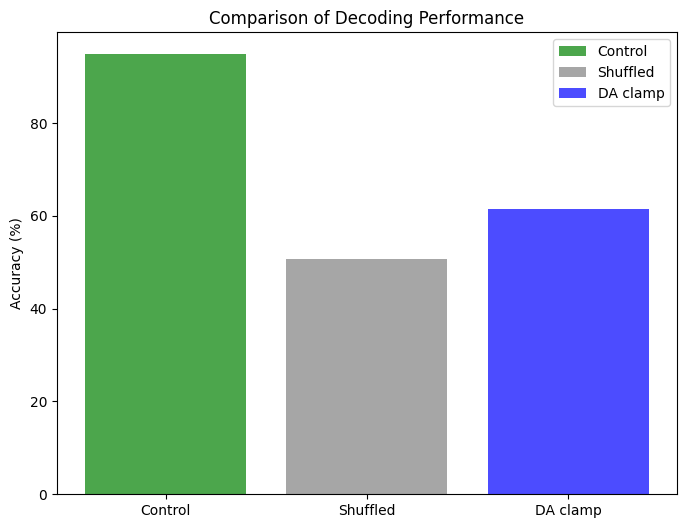

In [29]:
# ========================================
# 8. Create a Comparison Table
# ========================================

# Create a DataFrame to compare the metrics
comparison_data = {
    'Metric': ['Accuracy (%)', 'AUC'],
    'Control Group': [test_accuracy_control * 100, roc_auc_control],
    'Baseline Group': [baseline_accuracy * 100, '-'],  # No AUC for baseline
    'Inhibition Group': [test_accuracy_inhibition * 100, roc_auc_inhibition]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nComparison of Decoding Performance:")
print(comparison_df)

# Plot bar plot of accuracy
plt.figure(figsize=(8, 6))
plt.bar(1, comparison_df['Control Group'][0], color='g', alpha=0.7, label='Control')
plt.bar(2, comparison_df['Baseline Group'][0], color='gray', alpha=0.7, label='Shuffled')
plt.bar(3, comparison_df['Inhibition Group'][0], color='b', alpha=0.7, label='DA clamp')
plt.xticks([1, 2, 3], ['Control', 'Shuffled', 'DA clamp'])
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Decoding Performance')
plt.legend()
plt.show()


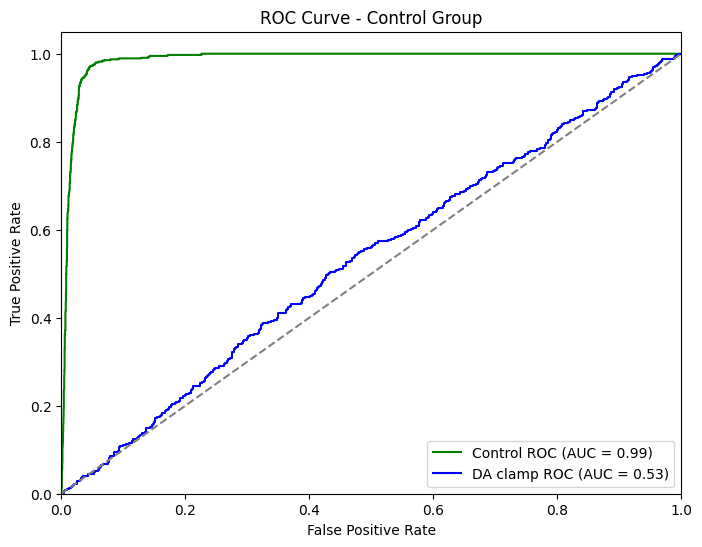

In [28]:
# ========================================
# 10. Plot ROC Curves
# ========================================

# ROC curve for control group
plt.figure(figsize=(8, 6))
plt.plot(fpr_control, tpr_control, color='green', label=f'Control ROC (AUC = {roc_auc_control:.2f})')
plt.plot(fpr_inhibition, tpr_inhibition, color='blue', label=f'DA clamp ROC (AUC = {roc_auc_inhibition:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier baseline
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Control Group')
plt.legend(loc='lower right')
plt.show()
